In [2]:
import sys
import os

In [3]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution
from utils import score
from typing import Callable

In [4]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [5]:
def ith_pair(i, n):
    a = math.floor((2*n - 1 - math.sqrt((2*n - 1)**2 - 8*i)) / 2)
    
    i_in_block = i - (a * (2*n - a - 1)) // 2

    b = a + 1 + i_in_block
    return (a, b)

n = 10
a = list()
c = 0
for i in range(n):
    tmp = list()
    for j in range(n):
        if i >= j:
            tmp.append(None)
        else:
            tmp.append(ith_pair(c, n))
            c += 1
    a.append(tmp)
a

[[None,
  (0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 6),
  (0, 7),
  (0, 8),
  (0, 9)],
 [None, None, (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9)],
 [None, None, None, (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9)],
 [None, None, None, None, (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9)],
 [None, None, None, None, None, (4, 5), (4, 6), (4, 7), (4, 8), (4, 9)],
 [None, None, None, None, None, None, (5, 6), (5, 7), (5, 8), (5, 9)],
 [None, None, None, None, None, None, None, (6, 7), (6, 8), (6, 9)],
 [None, None, None, None, None, None, None, None, (7, 8), (7, 9)],
 [None, None, None, None, None, None, None, None, None, (8, 9)],
 [None, None, None, None, None, None, None, None, None, None]]

In [126]:
class EdgeNeighborhood:
    def __init__(self, dist_mat, n) -> None:
        self.dist_mat = dist_mat
        self.indexes = list()
        for i in range(n-1):
            for j in range(i+1, n):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = solution[(j-1)%n]
        j2 = solution[j%n]
        j3 = solution[(j+1)%n]
        #edge case when two consecutive nodes selected
        if i-j == -1:
            return -self.dist_mat[i1, i2] - self.dist_mat[i2, j2] - self.dist_mat[j2, j3] \
                + self.dist_mat[i1, j2] + self.dist_mat[j2, i2] + self.dist_mat[i2, j3]
        
        difference = -self.dist_mat[i1, i2] - self.dist_mat[i2, i3] - self.dist_mat[j1, j2] - self.dist_mat[j2, j3] \
            + self.dist_mat[i1, j2] + self.dist_mat[j2, i3] + self.dist_mat[j1, i2] + self.dist_mat[i2, j3]
        return difference

In [109]:
class InterNeighborhood:
    def __init__(self, dist_mat, n) -> None:
        self.dist_mat = dist_mat 
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]

In [110]:
class CombinedNeighborhood:
    def __init__(self , neighborhoods) -> None:
        self.neighborhoods = neighborhoods
        self.size = sum(n.neighborhood_size() for n in self.neighborhoods)

    def neighborhood_size(self):
        return self.size
    
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

In [111]:
dist_m = np.random.randint(0, 10, size=(5,5))
for i in range(5):
    for j in range(5):
        if i == j:
            dist_m[i, j] = 0
        dist_m[i, j] = dist_m[j, i]
a = np.arange(5)
print(dist_m + a)
dist_m = dist_m + a


[[ 0  8  3  3  4]
 [ 7  1  6 12  7]
 [ 1  5  2  4  4]
 [ 0 10  3  3  9]
 [ 0  4  2  8  4]]


In [130]:
neighborhood1 = EdgeNeighborhood(dist_m, 3)
for i in range(neighborhood1.neighborhood_size()):
    print(neighborhood1.get_difference(i, [0, 1, 2], [3, 4]))


0
-2
0


In [131]:
neighborhood2 = InterNeighborhood(dist_m, 3)
for i in range(neighborhood2.neighborhood_size()):
    print(neighborhood2.get_difference(i, [0, 1, 2], [3, 4]))

5
-1
-8
-8
5
0


In [132]:
neighborhood3 = CombinedNeighborhood([neighborhood1, neighborhood2])
for i in range(neighborhood3.neighborhood_size()):
    print(neighborhood3.get_difference(i, [0, 1, 2], [3, 4]))

0
-2
0
5
-1
-8
-8
5
0


In [37]:
def greedy(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, get_neighborhood: Callable) -> list:
    cost_matrix = (distance_matrix + costs).T
    n = len(distance_matrix)
    num_nodes_to_use = n // 2

    get_neighborhood(starting_solution)

    return cycle

scores of nn:  105852 115630.16 123171
[159, 195, 146, 22, 20, 18, 108, 67, 36, 140, 93, 117, 170, 153, 183, 89, 23, 83, 64, 15, 9, 37, 128, 172, 57, 55, 3, 32, 49, 102, 144, 132, 21, 7, 164, 71, 27, 39, 165, 8, 185, 174, 81, 98, 17, 157, 188, 56, 171, 16, 78, 25, 44, 120, 2, 75, 86, 97, 189, 94, 130, 137, 66, 176, 80, 151, 133, 79, 63, 136, 53, 180, 154, 6, 135, 194, 161, 123, 29, 126, 112, 4, 190, 177, 147, 48, 34, 160, 184, 28, 43, 65, 197, 59, 118, 60, 46, 198, 139, 193]


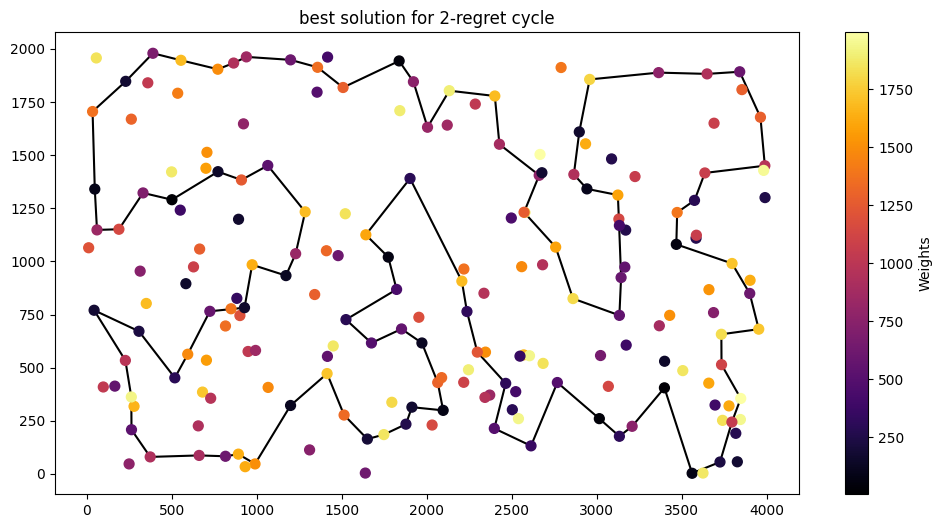

In [75]:
scores_2=[]
sols_2=[]

for x in range(200):
   
    solution_2=greedy_2_regret_cycle2(x, dist, costs)
    sols_2.append(solution_2)

    scores_2.append(score(solution_2, dist, costs))   

print('scores of nn: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
print(sols_2[scores_2.index(min(scores_2))])
plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, 'best solution for 2-regret cycle')
sol_1=np.array(sols_2[scores_2.index(min(scores_2))])
pd.DataFrame(sol_1).to_csv('sol_1.csv', header=False, index=False)

In [81]:
%%timeit
greedy_2_regret_cycle2(0, dist, costs)

12.3 ms ± 70.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
%%timeit
greedy_2_regret_weighted(0, dist, costs)

12.7 ms ± 193 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
